## ANLY 590 HW 1 Lasso/Ridge

### Xunge Jiang netid xj64

### 09/12

In [1]:
import pandas as pd 
hitters = pd.read_csv('Hitters.csv', sep=',', encoding='latin1')

## Preprocessing

In [2]:
hitter = hitters.drop('Unnamed: 0', axis = 1) # not include for lasso/ridge 
data = hitter[hitter.Salary.notnull()] # salary exists 
pred = hitter[hitter.Salary.isna()] # salary is nan 

dummies_data = pd.get_dummies(data[['League', 'Division', 'NewLeague']]) # create dummy variables 
dummies_pred = pd.get_dummies(pred[['League', 'Division', 'NewLeague']]) # create dummy variables 


# Drop the column salary (response), and columns that we created dummy variables on 
X_ = data.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X_pred_ = pred.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
 
#X = pd.concat([X_, dummies[['League_N', 'Division_W', 'NewLeague_N']]], axis = 1)
X = pd.concat([X_, dummies_data], axis = 1)
y = data['Salary']
X_pred = pd.concat([X_pred_, dummies_pred], axis = 1)


from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
X_train, X_test , y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1)

## Part 1.1 Lasso

#### Lasso: with different alphas for visualization of coefficient trajectories 

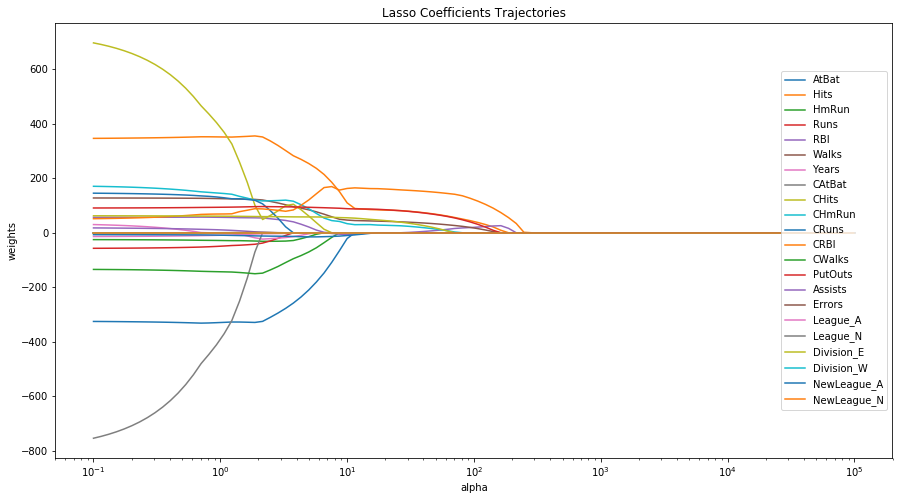

In [4]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
import numpy as np

n_alphas = 100
alphas = np.logspace(-1, 5, n_alphas)

coefs = []
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=False, max_iter=2000)
    lasso.fit(scale(X_train), y_train)
    coefs.append(lasso.coef_)

# plot trajectories 
plt.figure(figsize=(15,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso Coefficients Trajectories')
plt.axis('tight')
ax.legend(X_train.columns, loc = 'right')
plt.show()

In [5]:
# last three predictors 
# From the plot, we can see when alpha approaches 160 to 170, about 3-5 predictors left. 
lasso_a170 = Lasso(alpha=170, fit_intercept=False, max_iter=2000)
lasso_a170.fit(scale(X_train), y_train)
print(pd.Series(lasso_a170.coef_, index = X_train.columns)) 

AtBat           0.000000
Hits            3.830835
HmRun           0.000000
Runs            0.000000
RBI            25.429706
Walks           0.000000
Years           0.000000
CAtBat          0.000000
CHits           0.000000
CHmRun          0.000000
CRuns           0.000000
CRBI           68.440671
CWalks          0.000000
PutOuts         0.000000
Assists         0.000000
Errors          0.000000
League_A        0.000000
League_N       -0.000000
Division_E      0.000000
Division_W     -0.000000
NewLeague_A     0.000000
NewLeague_N    -0.000000
dtype: float64


## Result:
1) From the plot, we can see when alpha approaches 160 to 170, about 3-5 predictors left, including Hits, CRBI and RBI. <br/>

2) By checking the lasso coefficient at alpha = 170, last three variables left in the lasso regression is 'Hits', 'CRBI', and 'RBI'.

### Lasso: Use cross-validation to find optimal alpha 

In [6]:
lassocv = LassoCV(alphas = None, cv = 5, fit_intercept=False, max_iter=2000)
lassocv.fit(scale(X_train), y_train)
print('The optimal value of the penalty from cross-validation is:', lassocv.alpha_)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(scale(X_train), y_train)
print(pd.Series(lasso.coef_, index = X_train.columns)) 

The optimal value of the penalty from cross-validation is: 23.269229402397862
AtBat            0.000000
Hits            82.245087
HmRun            0.000000
Runs             0.000000
RBI              0.000000
Walks           40.942256
Years            0.000000
CAtBat           0.000000
CHits            0.000000
CHmRun          26.496978
CRuns            0.000000
CRBI           158.920284
CWalks           0.000000
PutOuts         82.723451
Assists         -0.000000
Errors          -0.000000
League_A        -0.000000
League_N         0.000000
Division_E      41.691731
Division_W      -0.000000
NewLeague_A     -0.000000
NewLeague_N      0.000000
dtype: float64


## Result: 6 values are left in this model. 

## Part 1.2 Ridge 

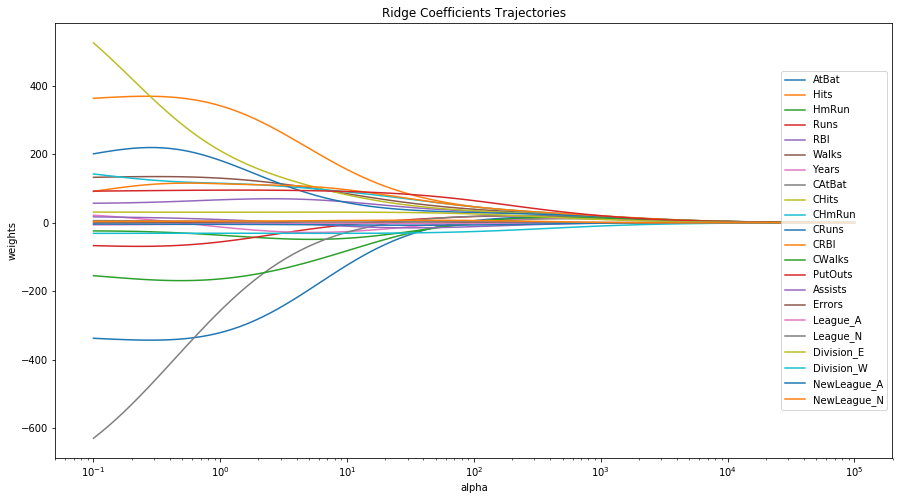

In [7]:
n_alphas = 100
alphas = np.logspace(-1, 5, n_alphas)

coefs = []
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(scale(X_train), y_train)
    coefs.append(ridge.coef_)

# plot trajectories - cannot eliminate attributes
plt.figure(figsize=(15,8))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge Coefficients Trajectories')
ax.legend(X_train.columns, loc = 'right')
plt.axis('tight')
plt.show()


### Ridge: Use cross-validation to find optimal alpha 

In [8]:
ridgecv = RidgeCV(alphas = alphas, cv = 5, fit_intercept=False)
ridgecv.fit(scale(X_train), y_train)
print('The optimal value of the penalty from cross-validation is:', ridgecv.alpha_)

The optimal value of the penalty from cross-validation is: 247.70763559917114


## Part 2

Variance measures the amount that the estimate of the model will change if different training data is used. Ideally, it should not change too much from one training dataset to the next.In general, more flexible statistical methods have higher variance. 
Bias refers to the error that is introduced by approximating a real-life problem, which may be extremely complicated, by a much simpler model. Models with low bias will learn faster and be understood easier but generally less flexible. 

Thus, there is a tradeoff between variance and bias. It is easy to obtain a method with extremely low bias but high variance or a method with very low variance but high bias.  

We would want to have a trade-off between these two error components. Linear regression is a machine learning model that can be easily overfitted or underfitted. To avoid the problems and deal with highly correlated variables, we introduce the regularization. 

From part 1.1, we can see that Ridge Regression performs regularization while Lasso regression performs both variable selection (eliminate a lot of variables when alpha increases) and regularization. Just like Ridge Regression, Lasso Regression also trades off an increase in bias with a decrease in variance. However, Lasso regression goes to an extent where it enforces the coefficients of X variables to become 0 and reduces the model complexity using regularization. Generally speaking, the bias increases as alpha (amount of shrinkage) increases and the variance decreases as alpha (amount of shrinkage) increases. 